In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import math
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
dataframe = pd.read_csv('../01.data/PeopleCountData_wide.txt',sep='|')
dataframe['timestamp'] = pd.to_datetime(dataframe.timestamp)
dataframe['date'] = dataframe.timestamp.dt.date
dataframe['hour'] = dataframe.timestamp.dt.hour

In [4]:
dataframe.head(2)

timestamp  incoming_CarlsonBridgeEntrance  \
0 2017-05-04 15:51:00                             0.0   
1 2017-05-04 15:53:00                             0.0   

   incoming_CarlsonBridgeEntrance.Counter  incoming_CarlsonMainEntrance  \
0                                     0.0                           0.0   
1                                     0.0                           0.0   

   incoming_CarlsonMainEntrance.Counter  incoming_CarlsonTunnelEntrance  \
0                                   0.0                             0.0   
1                                   0.0                             0.0   

   incoming_CarlsonTunnelEntrance.Counter  incoming_DouglassBridge  \
0                                     0.0                      0.0   
1                                     0.0                      5.0   

   incoming_FriedlanderLobby  incoming_GleasonEntrance  ...   \
0                        0.0                       0.0  ...    
1                        6.0                       3.0  ...    

   outgoing_DouglassBridge  outgoing_FriedlanderLobby  \
0                      0.0                        0.0   
1                      4.0                        4.0   

   outgoing_GleasonEntrance  outgoing_GleasonStacks  outgoing_POAMainEntrance  \
0                       0.0                     0.0                       0.0   
1                       5.0                     6.0                       0.0   

   outgoing_POAMainEntrance.Counter  outgoing_RobbinsLibrary  \
0                               0.0                      0.0   
1                               0.0                      0.0   

   outgoing_RobbinsLibrary.Counter        date  hour  
0                              0.0  2017-05-04    15  
1                              0.0  2017-05-04    15  

[2 rows x 31 columns]

## LSTM Network for Regression

In [5]:
cols_to_drop = [
                 'timestamp',
                 'hour',
                 'incoming_CarlsonBridgeEntrance',
                 'incoming_CarlsonBridgeEntrance.Counter',
                 'incoming_CarlsonMainEntrance',
                 'incoming_CarlsonMainEntrance.Counter',
                 'incoming_CarlsonTunnelEntrance',
                 'incoming_CarlsonTunnelEntrance.Counter',
                 'incoming_POAMainEntrance',
                 'incoming_POAMainEntrance.Counter',
                 'incoming_RobbinsLibrary',
                 'incoming_RobbinsLibrary.Counter',
                 'outgoing_CarlsonBridgeEntrance',
                 'outgoing_CarlsonBridgeEntrance.Counter',
                 'outgoing_CarlsonMainEntrance',
                 'outgoing_CarlsonMainEntrance.Counter',
                 'outgoing_CarlsonTunnelEntrance',
                 'outgoing_CarlsonTunnelEntrance.Counter',
                 'outgoing_POAMainEntrance',
                 'outgoing_POAMainEntrance.Counter',
                 'outgoing_RobbinsLibrary',
                 'outgoing_RobbinsLibrary.Counter'
                ]

In [6]:
# fix random seed for reproducibility

np.random.seed(7)

for column in cols_to_drop:
    del dataframe[column]
    
# load the dataset

dataframe_grouped = dataframe.groupby('date').sum()
dataframe_grouped['weekday'] = pd.to_datetime(dataframe_grouped.index).weekday

mu = dataframe_grouped[(dataframe_grouped<4000)].mean(0)['outgoing_DouglassBridge']
dataframe_grouped.outgoing_DouglassBridge.loc[dataframe_grouped.outgoing_DouglassBridge>4000] = mu


dataset = dataframe_grouped.values
dataset = dataset.astype('float32')

/home/npatil4/.local/lib/python2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
# normalize the dataset

scaler = MinMaxScaler(feature_range=(0, 1))
dataset[:,:-1] = scaler.fit_transform(dataset[:,:-1])

In [10]:
# split into train and test sets

train_size = int(len(dataset) * 0.85)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

train.shape,test.shape

((232, 9), (42, 9))

In [11]:
# convert an array of values into a dataset matrix

def create_dataset(dataset_in, look_back=1):
    
    dataX, dataY = [], []
    
    for i in range(len(dataset_in)-look_back-1):
        
        a = dataset_in[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset_in[i + look_back, :-1])
        
    return np.array(dataX), np.array(dataY)

In [12]:
# reshape into X=t and Y=t+1

look_back = 2

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX.shape, trainY.shape,testX.shape, testY.shape

((229, 2, 9), (229, 8), (39, 2, 9), (39, 8))

In [13]:
run = '05_new_128_nodes'

In [14]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

ES = EarlyStopping(patience=20)

MC = ModelCheckpoint(filepath='../05.model/model_'+run+'.h5')

In [27]:
from keras.layers import Dropout
from keras.optimizers import Adam
from keras import backend as K

batch_size = 1

# create and fit the LSTM network

K.clear_session()
input_shape = ((trainX.shape[1],trainX.shape[-1]))
num_classes = trainY.shape[-1]

model = Sequential()

model.add(LSTM(units = 128,input_shape=input_shape))

model.add(Dense(256,activation='relu'))

model.add(Dense(num_classes,activation='relu'))

model.compile(loss='mse', optimizer='adam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               70656     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 2056      
Total params: 105,736
Trainable params: 105,736
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(trainX, trainY, 
          epochs=1000, 
          batch_size=batch_size,
          validation_split=0.1,
          callbacks=[ES,MC], 
          verbose=2, 
          shuffle=False)

#model.save('../05.model/model_'+run+'.h5')

In [29]:
from keras.models import load_model
model = load_model('../05.model/model_'+run+'.h5')

# make predictions

trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()

testPredict = model.predict(testX, batch_size=batch_size)

# invert predictions

trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform(testY)


# calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(trainY_actual, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_actual, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 237.71 RMSE
Test Score: 351.36 RMSE


In [30]:
# make predictions

trainPredict = model.predict(trainX, batch_size=batch_size)

testPredict = model.predict(testX, batch_size=batch_size)

In [31]:
trainX.shape

(229, 2, 9)

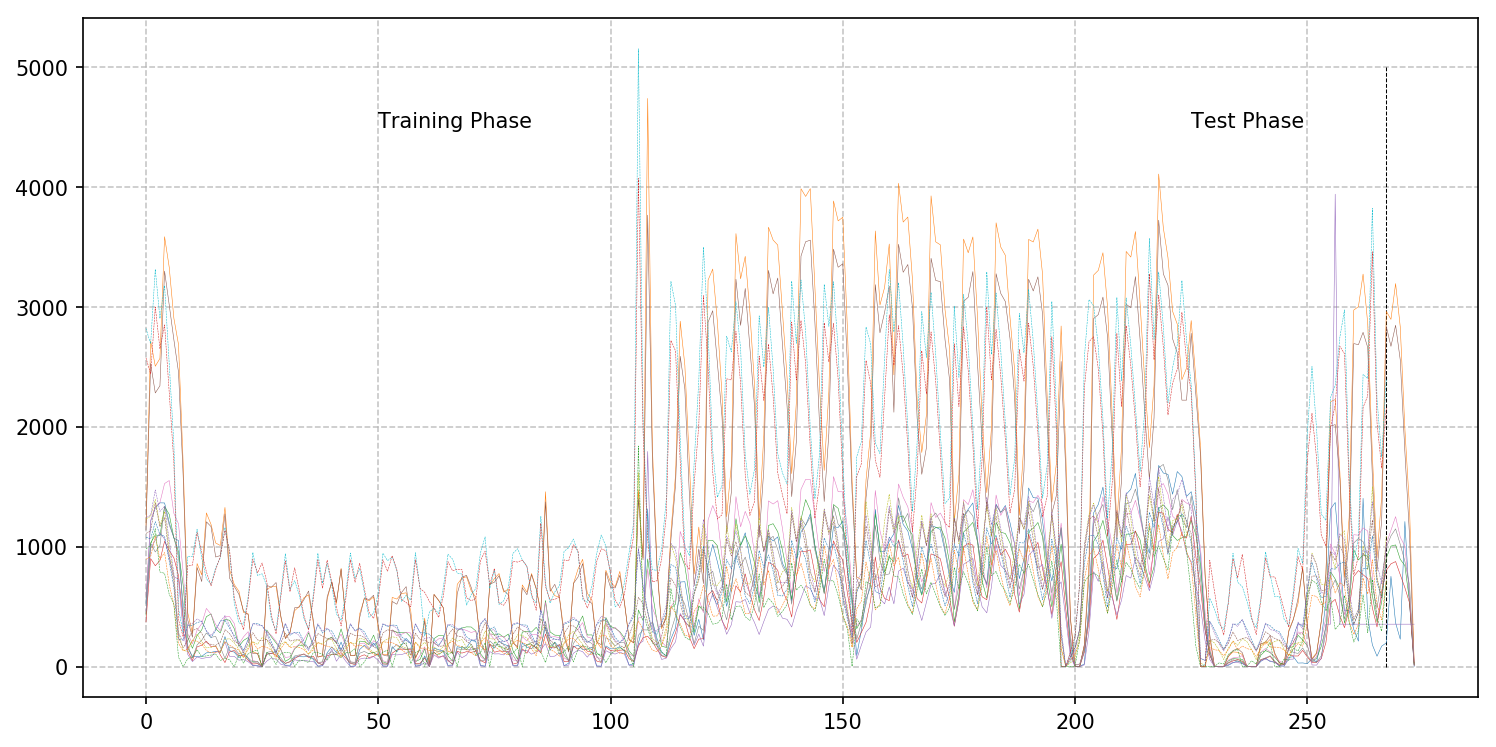

In [32]:
# plot baseline and predictions

actualPlot = scaler.inverse_transform(dataset[:,:-1])
predictPlot = scaler.inverse_transform(np.concatenate([trainPredict,testPredict]))

plt.figure(figsize=(12,6),dpi=150)
plt.plot(actualPlot, ls='-', lw=0.25)
plt.plot(predictPlot, ls='--', lw=0.25)
plt.vlines(x = actualPlot.shape[0]-7, ymin=0, ymax=5000, linestyles='dashed',lw=0.5)
#plt.axis([0,260,0,5000])
plt.grid(ls='--',lw=0.75,alpha=0.75)
plt.text(50,4500,'Training Phase')
plt.text(225,4500,'Test Phase');